In [1]:
#highly useful to convert arrays in txt file into numpy array 
def string_to_array(file_name):
    import ast
    arr = []
    with open(file_name, 'r') as infp:
        for l in infp:
            arr.append(ast.literal_eval('[%s]' % l))  # replace with eval() if you trust your input data

    return(arr)

In [ ]:
#First we find the true distance matrix for the point cloud data in the simulation box with the following script.
#
#Input:  point_cloud = [[x1, y1, z1], ..., [zN, yN, zN]] is an Nx3 array where N is the number of points in the 
#       simulation box and where the i-th row equals the xyz coordinates [xi, yi, zi] of the i-th point. 
#       dimensions = [x1, x2, y1, y2, z1, z2] denotes the dimensions of the simulation box, where it is required
#       that x2 > x1, y2 > y1, and z2 > z1. 
#
#Output: d is an NxN distance matrix where each ij-th entry is the distance between particles i and j. The distance
#       takes into account the periodic boundary. Mathematically, the simulation box is a 3-dimensional torus and 
#       therefore d[i, j] equals the mininum of |i - j_r| where j_r ranges over all 27 points which correspond to j
#       which are contained in the 27 boxes that are adjacent to B. 
#
#EXAMPLE: If B were a box in two dimensions, we would have 9 adjacent boxes (B is adjacent to itself) which j_r can 
#       be a point inside of as the following figure describes. In 3D, we have. 3 copies of the figure stacked 
#       on-top of one another, with B as the center cube. 
#
#
#        Figure:
#
#    y2- ***  ***  ***
#        *1*  *2*  *3*
#        ***  ***  ***
#
#        ***  ***  ***
#        *4*  *B*  *6*
#        ***  ***  ***
#
#        ***  ***  ***
#        *7*  *8*  *9*
#    y1- ***  ***  ***
#        |           |
#        x1          x2

from scipy.spatial import distance
import numpy.matlib

def torus_distance_matrix(point_cloud, dimensions_of_box):
    [x1, x2, y1, y2, z1, z2] = dimensions_of_box;
    e1 = np.array([x2 - x1, 0, 0]);
    e2 = np.array([0, y2 - y1, 0]);
    e3 = np.array([0, 0, z2 - z1]);
    
    sim_box_reflections = [[0, 0, 0], e1, np.add(e1, -e2), -e2, np.add(-e1,-e2), -e1, np.add(-e1,e2), e2, np.add(e1,e2)];
    sim_box_reflections = np.concatenate((sim_box_reflections, np.add(sim_box_reflections, e3), np.add(sim_box_reflections, -e3)), axis=0);
    
    d = np.zeros((len(point_cloud), len(point_cloud)));
    
    for ii in range(len(point_cloud)):
        ii_xyz = point_cloud[ii, :];
        
        for jj in range(len(point_cloud)):
            if ii == jj:
                continue;
                
            else:
                jj_xyz = point_cloud[jj, :];
                jj_reflected = np.add(np.matlib.repmat(jj_xyz, 27, 1) , sim_box_reflections);
                d_ii_jj_reflected = distance.pdist(np.concatenate(([ii_xyz], jj_reflected), axis = 0));
                d_ii_jj = min(d_ii_jj_reflected[0:27]);
                
                d[ii, jj] = d_ii_jj;
                d[jj, ii] = d_ii_jj;
                
    return(d);       


# functions useful for persistent homology calculations

In [ ]:
#it converts xyz coordinates into array of coordinates. It includes all the coordinates that is present in the xyz file. 
#it skips first two line of xyz as it does not coordinate information
#example usage: array = xyz_to_array_of_coordinates(""DMDBT_cn_500_1p5.xyz")
def xyz_to_array_of_coordinates(file_name):
    import numpy as np
    
    f = open(file_name,'r')
    
    g = open("corrected-coord.txt", "w")
    
    for line in f:
        if line.strip():
            g.write("\t".join(line.split()[1:]) + "\n")
    f.close()

    fl_coords = []
    with open("corrected-coord.txt", "r") as g:
        lines = g.readlines()
        d_lines = lines[1:]

        for i in d_lines:
        
            coords = [np.array(i.replace("'", "").rstrip('\n').replace('\t', ' ').split(' '))]
            for arr in coords:
                l = arr.astype(float)
                fl_coords.append(l)

        arr = np.asarray(fl_coords)
    return(arr)

In [ ]:
#example usage: mat = mat_from_two_atom_approach_malonamide(array,903,'HEMA')
#array can be generated using another function: array = xyz_to_array_of_coordinates(""DMDBT_cn_500_1p5.xyz")
def mat_from_two_atom_approach_malonamide(array,num_of_molecules,system):
    import numpy as np
    from math import sqrt
    
    system = system
    length = num_of_molecules
    split = np.array_split(array,length)
    
    d_line = []
    for i in split:
        if system == 'HEMA':
            x1 = i[28]
            d_line.append(x1)
            x4 = i[32]
            d_line.append(x4)

        if system == 'TDMA':
            x1 = i[27]
            d_line.append(x1)
            x4 = i[29]
            d_line.append(x4)
        
    split = np.array_split(d_line,length)
        
    dim = length*2
    mat = np.zeros((dim,dim))
    ndx = 0
    mdx = 0

    for i in range(len(split)):
        for odx,k in enumerate(split[i]):
            ndx += 1
            mdx = 0
            for j in range(len(split)):
                for jdx, l in enumerate(split[j]):
                    mdx += 1

                    #one to one interaction and intramolecular atoms are at infinite position
                    if i == j:
                        mat[ndx-1][mdx-1] = 100
                        mat[mdx-1][ndx-1] = 100
                    if i != j and odx == jdx:
                        dist = sqrt(([k][0][0] - [l][0][0])**2 + ([k][0][1] - [l][0][1])**2 + ([k][0][2] - [l][0][2])**2)
                        mat[ndx-1][mdx-1] = dist
                        mat[mdx-1][ndx-1] = dist
                    if i != j and odx != jdx:
                        mat[ndx-1][mdx-1] = 100
                        mat[mdx-1][ndx-1] = 100
    return(mat, d_line)

In [1]:
#example usage: mat = mat_from_two_atom_approach_malonamide(array,903,'HEMA')
#array can be generated using another function: array = xyz_to_array_of_coordinates(""DMDBT_cn_500_1p5.xyz")
def mat_from_one_atom_approach_malonamide(array,num_of_molecules,system):
    import numpy as np
    from math import sqrt
    from scipy.spatial.distance import squareform, pdist
    import pandas as pd

    system = system
    length = num_of_molecules
    split = np.array_split(array,length)
    
    d_line = []
    for i in split:
        if system == 'HEMA':
            x1 = i[0]
            d_line.append(x1)
            
        if system == 'TDMA':
            x1 = i[5]
            d_line.append(x1)
        
    mat = squareform(pdist(d_line, 'euclidean'))
        
    return(mat, d_line)

In [1]:
#generate birth_death array (aka. diag) from a distance matrix
#example usage: diag = get_diag_from_distance_matrix(mat,3,30,0)
def get_diag_from_distance_matrix(mat,max_dimension_in_it,max_edge_length_in_it,min_persistence_in_it):
    
    import gudhi as gd
    
    skeleton_0 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length_in_it)
    Rips_simplex_tree_0 = skeleton_0.create_simplex_tree(max_dimension=max_dimension_in_it)
    Rips_simplex_tree_0.dimension()
    diag = Rips_simplex_tree_0.persistence(min_persistence=min_persistence_in_it)
    return(Rips_simplex_tree_0,diag)

In [7]:
#distance matrix, numpy array of coordinates (d_line), max_edge_length = [10,15,20,25], maximum four item in max edge length is allowed

def visualize_triag_vr_from_distance_matrix(fig_name, mat,d_line,max_edge_length,min_persistence_in_it):
    import numpy as np
    import gudhi as gd
    import matplotlib.pyplot as plt
    from math import sqrt
    import numpy as np
    import gudhi
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from matplotlib.widgets import Slider
    
    
    skeleton_0 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[0])
    Rips_simplex_tree_0 = skeleton_0.create_simplex_tree(max_dimension=3)

    skeleton_1 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[1])
    Rips_simplex_tree_1 = skeleton_1.create_simplex_tree(max_dimension=3)

    skeleton_2 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[2])
    Rips_simplex_tree_2 = skeleton_2.create_simplex_tree(max_dimension=3)

    skeleton_3 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[3])
    Rips_simplex_tree_3 = skeleton_3.create_simplex_tree(max_dimension=3)


    triangles_0 = np.array([s[0] for s in Rips_simplex_tree_0.get_skeleton(2) if len(s[0])==3])
    triangles_1 = np.array([s[0] for s in Rips_simplex_tree_1.get_skeleton(2) if len(s[0])==3])
    triangles_2 = np.array([s[0] for s in Rips_simplex_tree_2.get_skeleton(2) if len(s[0])==3])
    triangles_3 = np.array([s[0] for s in Rips_simplex_tree_3.get_skeleton(2) if len(s[0])==3])

    d_line = np.array(d_line)/10

    # Visualization with matplotlib
    fig = plt.figure(figsize=(16,14))

    #fig,((ax0,ax1),(ax2,ax3)) = plt.subplots(ncols=2, nrows=2,figsize=(16, 14))

    r = [0,10]
    X, Y = np.meshgrid(r, r)
    one = [[0, 0],[0, 0]]
    one = np.array(one)
    hundred = [[10, 10],[10, 10]]
    hundred = np.array(hundred)

    #ax0
    #ax0 = fig.gca(projection='3d') 
    ax0 = fig.add_subplot(221, projection='3d')
    if triangles_0.size > 0:
        surf0 = ax0.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_0,antialiased=True, color='r',edgecolor='black',alpha=0.5, linewidth=0.01)
    ax0.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax0.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax0.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax0.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax0.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax0.set_xlim(0, 10)
    ax0.set_ylim(0, 10)
    ax0.set_zlim(0, 10)
    ax0.xaxis.pane.fill = False
    ax0.yaxis.pane.fill = False
    ax0.zaxis.pane.fill = False
    ax0.xaxis.pane.set_edgecolor('w')
    ax0.yaxis.pane.set_edgecolor('w')
    ax0.zaxis.pane.set_edgecolor('w')
    ax0.tick_params(axis='both', which='major', labelsize=17)
    ax0.grid(False)
    ax0.view_init(-165, 30)

    #ax1
    #ax1 = fig.gca(projection='3d') 
    ax1 = fig.add_subplot(222, projection='3d')
    if triangles_1.size > 0:
        surf1 = ax1.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_1, antialiased=True, color='r',edgecolor='black',alpha=0.5, linewidth=0.01)
    ax1.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax1.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax1.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax1.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax1.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax1.set_xlim(-.2, 10.4)
    ax1.set_ylim(-.4, 10.4)
    ax1.set_zlim(-.4, 10.4)
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.xaxis.pane.set_edgecolor('w')
    ax1.yaxis.pane.set_edgecolor('w')
    ax1.zaxis.pane.set_edgecolor('w')
    ax1.tick_params(axis='both', which='major', labelsize=17)
    ax1.grid(False)
    ax1.view_init(-165, 30)

    #ax2
    #ax2 = fig.gca(projection='3d') 
    ax2 = fig.add_subplot(223, projection='3d')
    if triangles_2.size > 0:
        surf2 = ax2.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_2, antialiased=True, color='r',edgecolor='black',alpha=0.5, linewidth=0.01)
    ax2.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax2.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax2.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax2.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax2.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax2.set_xlim(-.2, 10.4)
    ax2.set_ylim(-.4, 10.4)
    ax2.set_zlim(-.4, 10.4)
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    ax2.xaxis.pane.set_edgecolor('w')
    ax2.yaxis.pane.set_edgecolor('w')
    ax2.zaxis.pane.set_edgecolor('w')
    ax2.tick_params(axis='both', which='major', labelsize=17)
    ax2.grid(False)
    ax2.view_init(-165, 30)

    #ax3
    #ax3 = fig.gca(projection='3d') 
    ax3 = fig.add_subplot(224, projection='3d')
    if triangles_3.size > 0:
        surf3 = ax3.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_3, antialiased=True, color='r',edgecolor='black',alpha=0.5, linewidth=0.01)
    ax3.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax3.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax3.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax3.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax3.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax3.set_xlim(-.2, 10.4)
    ax3.set_ylim(-.4, 10.4)
    ax3.set_zlim(-.4, 10.4)
    ax3.xaxis.pane.fill = False
    ax3.yaxis.pane.fill = False
    ax3.zaxis.pane.fill = False
    ax3.xaxis.pane.set_edgecolor('w')
    ax3.yaxis.pane.set_edgecolor('w')
    ax3.zaxis.pane.set_edgecolor('w')
    ax3.tick_params(axis='both', which='major', labelsize=17)
    ax3.grid(False)
    ax3.view_init(-165, 30)


    plt.tight_layout()
    fig = plt.savefig(fig_name + ".png",dpi=600)
    
    return(fig)

In [ ]:
#distance matrix, numpy array of coordinates (d_line), max_edge_length = [10,15,20,25], maximum four item in max edge length is allowed

def visualize_triag_vr_from_distance_matrix_with_scatter(fig_name, mat,d_line,max_edge_length,min_persistence_in_it):
    import numpy as np
    import gudhi as gd
    import matplotlib.pyplot as plt
    from math import sqrt
    import numpy as np
    import gudhi
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from matplotlib.widgets import Slider
    
    
    skeleton_0 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[0])
    Rips_simplex_tree_0 = skeleton_0.create_simplex_tree(max_dimension=3)

    skeleton_1 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[1])
    Rips_simplex_tree_1 = skeleton_1.create_simplex_tree(max_dimension=3)

    skeleton_2 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[2])
    Rips_simplex_tree_2 = skeleton_2.create_simplex_tree(max_dimension=3)

    skeleton_3 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[3])
    Rips_simplex_tree_3 = skeleton_3.create_simplex_tree(max_dimension=3)


    triangles_0 = np.array([s[0] for s in Rips_simplex_tree_0.get_skeleton(2) if len(s[0])==3])
    triangles_1 = np.array([s[0] for s in Rips_simplex_tree_1.get_skeleton(2) if len(s[0])==3])
    triangles_2 = np.array([s[0] for s in Rips_simplex_tree_2.get_skeleton(2) if len(s[0])==3])
    triangles_3 = np.array([s[0] for s in Rips_simplex_tree_3.get_skeleton(2) if len(s[0])==3])

    d_line = np.array(d_line)/10

    # Visualization with matplotlib
    fig = plt.figure(figsize=(16,14))

    #fig,((ax0,ax1),(ax2,ax3)) = plt.subplots(ncols=2, nrows=2,figsize=(16, 14))

    r = [0,10]
    X, Y = np.meshgrid(r, r)
    one = [[0, 0],[0, 0]]
    one = np.array(one)
    hundred = [[10, 10],[10, 10]]
    hundred = np.array(hundred)

    #ax0
    #ax0 = fig.gca(projection='3d') 
    ax0 = fig.add_subplot(221, projection='3d')
    ax0.scatter(d_line[:,0], d_line[:,1], d_line[:,2], s=np.pi*1**2*200, alpha=0.5, marker='o',c='black', depthshade=False,facecolors='none')
    if triangles_0.size > 0:
        surf0 = ax0.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_0,antialiased=True, color='r',edgecolor='black',alpha=0.5, linewidth=0.01)
    ax0.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax0.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax0.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax0.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax0.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax0.set_xlim(0, 10)
    ax0.set_ylim(0, 10)
    ax0.set_zlim(0, 10)
    ax0.xaxis.pane.fill = False
    ax0.yaxis.pane.fill = False
    ax0.zaxis.pane.fill = False
    ax0.xaxis.pane.set_edgecolor('w')
    ax0.yaxis.pane.set_edgecolor('w')
    ax0.zaxis.pane.set_edgecolor('w')
    ax0.tick_params(axis='both', which='major', labelsize=17)
    ax0.grid(False)
    ax0.view_init(-165, 30)

    #ax1
    #ax1 = fig.gca(projection='3d') 
    ax1 = fig.add_subplot(222, projection='3d')
    ax1.scatter(d_line[:,0], d_line[:,1], d_line[:,2], s=np.pi*1**2*300, alpha=0.5, marker='o',c='black', depthshade=False,facecolors='none')
    if triangles_1.size > 0:
        surf1 = ax1.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_1, antialiased=True, color='r',facecolor='black',alpha=0.5, linewidth=0.01)
    ax1.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax1.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax1.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax1.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax1.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.set_zlim(0, 10)
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.xaxis.pane.set_edgecolor('w')
    ax1.yaxis.pane.set_edgecolor('w')
    ax1.zaxis.pane.set_edgecolor('w')
    ax1.tick_params(axis='both', which='major', labelsize=17)
    ax1.grid(False)
    ax1.view_init(-165, 30)

    #ax2
    #ax2 = fig.gca(projection='3d') 
    ax2 = fig.add_subplot(223, projection='3d')
    ax2.scatter(d_line[:,0], d_line[:,1], d_line[:,2], s=np.pi*1**2*400, alpha=0.5, marker='o',c='black', depthshade=False,facecolors='none')
    
    
    if triangles_2.size > 0:
        surf2 = ax2.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_2, antialiased=True, color='r',edgecolor='black',alpha=0.5, linewidth=0.01)
    ax2.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax2.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax2.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax2.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax2.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    ax2.set_zlim(0, 10)
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    ax2.xaxis.pane.set_edgecolor('w')
    ax2.yaxis.pane.set_edgecolor('w')
    ax2.zaxis.pane.set_edgecolor('w')
    ax2.tick_params(axis='both', which='major', labelsize=17)
    ax2.grid(False)
    ax2.view_init(-165, 30)

    #ax3
    #ax3 = fig.gca(projection='3d') 
    ax3 = fig.add_subplot(224, projection='3d')
    ax3.scatter(d_line[:,0], d_line[:,1], d_line[:,2], s=np.pi*1**2*500, alpha=0.5, marker='o',c='black', depthshade=False,facecolors='none')
    
    if triangles_3.size > 0:
        surf3 = ax3.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_3, antialiased=True, color='r',edgecolor='black',alpha=0.5, linewidth=0.01)
    ax3.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax3.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax3.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax3.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax3.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 10)
    ax3.set_zlim(0, 10)
    ax3.xaxis.pane.fill = False
    ax3.yaxis.pane.fill = False
    ax3.zaxis.pane.fill = False
    ax3.xaxis.pane.set_edgecolor('w')
    ax3.yaxis.pane.set_edgecolor('w')
    ax3.zaxis.pane.set_edgecolor('w')
    ax3.tick_params(axis='both', which='major', labelsize=17)
    ax3.grid(False)
    ax3.view_init(-165, 30)
    


    plt.tight_layout()
    fig = plt.savefig(fig_name + ".png",dpi=600)
    
    return(fig)

In [ ]:
#distance matrix, numpy array of coordinates (d_line), max_edge_length = [10,15,20,25], maximum four item in max edge length is allowed

def visualize_triag_vr_from_distance_matrix_with_scatter_side_view(fig_name, mat,d_line,max_edge_length,min_persistence_in_it):
    import numpy as np
    import gudhi as gd
    import matplotlib.pyplot as plt
    from math import sqrt
    import numpy as np
    import gudhi
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from matplotlib.widgets import Slider
    
    
    skeleton_0 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[0])
    Rips_simplex_tree_0 = skeleton_0.create_simplex_tree(max_dimension=3)

    skeleton_1 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[1])
    Rips_simplex_tree_1 = skeleton_1.create_simplex_tree(max_dimension=3)

    skeleton_2 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[2])
    Rips_simplex_tree_2 = skeleton_2.create_simplex_tree(max_dimension=3)

    skeleton_3 = gd.RipsComplex(distance_matrix=mat, max_edge_length=max_edge_length[3])
    Rips_simplex_tree_3 = skeleton_3.create_simplex_tree(max_dimension=3)


    triangles_0 = np.array([s[0] for s in Rips_simplex_tree_0.get_skeleton(2) if len(s[0])==3])
    triangles_1 = np.array([s[0] for s in Rips_simplex_tree_1.get_skeleton(2) if len(s[0])==3])
    triangles_2 = np.array([s[0] for s in Rips_simplex_tree_2.get_skeleton(2) if len(s[0])==3])
    triangles_3 = np.array([s[0] for s in Rips_simplex_tree_3.get_skeleton(2) if len(s[0])==3])

    d_line = np.array(d_line)/10

    # Visualization with matplotlib
    fig = plt.figure(figsize=(16,14))

    #fig,((ax0,ax1),(ax2,ax3)) = plt.subplots(ncols=2, nrows=2,figsize=(16, 14))

    r = [0,10]
    X, Y = np.meshgrid(r, r)
    one = [[0, 0],[0, 0]]
    one = np.array(one)
    hundred = [[10, 10],[10, 10]]
    hundred = np.array(hundred)

    #ax0
    #ax0 = fig.gca(projection='3d') 
    ax0 = fig.add_subplot(221, projection='3d')
    ax0.scatter(d_line[:,0], d_line[:,1], d_line[:,2], s=np.pi*1**2*60, alpha=0.2, marker='o',edgecolors = 'black',depthshade=False,facecolors='none')
    if triangles_0.size > 0:
        surf0 = ax0.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_0,antialiased=True, color='r',edgecolor='black',alpha=0.5, linewidth=0.01)
    ax0.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax0.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax0.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax0.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax0.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax0.set_xlim(0, 10)
    ax0.set_ylim(0, 10)
    ax0.set_zlim(0, 10)
    ax0.xaxis.pane.fill = False
    ax0.yaxis.pane.fill = False
    ax0.zaxis.pane.fill = False
    ax0.xaxis.pane.set_edgecolor('w')
    ax0.yaxis.pane.set_edgecolor('w')
    ax0.zaxis.pane.set_edgecolor('w')
    ax0.tick_params(axis='both', which='major', labelsize=17)
    ax0.grid(False)
    ax0.set_axis_off()
    ax0.view_init(0, 90)

    #ax1
    #ax1 = fig.gca(projection='3d') 
    ax1 = fig.add_subplot(222, projection='3d')
    ax1.scatter(d_line[:,0], d_line[:,1], d_line[:,2], s=np.pi*1**2*150, alpha=0.2, marker='o',edgecolors = 'black',depthshade=False,facecolors='none')
    if triangles_1.size > 0:
        surf1 = ax1.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_1, antialiased=True, color='r',facecolor='black',alpha=0.5, linewidth=0.01)
    ax1.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax1.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax1.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax1.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax1.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    ax1.set_zlim(0, 10)
    ax1.xaxis.pane.fill = False
    ax1.yaxis.pane.fill = False
    ax1.zaxis.pane.fill = False
    ax1.xaxis.pane.set_edgecolor('w')
    ax1.yaxis.pane.set_edgecolor('w')
    ax1.zaxis.pane.set_edgecolor('w')
    ax1.tick_params(axis='both', which='major', labelsize=17)
    ax1.grid(False)
    ax1.set_axis_off()
    ax1.view_init(0, 90)
    
    #ax2
    #ax2 = fig.gca(projection='3d') 
    ax2 = fig.add_subplot(223, projection='3d')
    ax2.scatter(d_line[:,0], d_line[:,1], d_line[:,2], s=np.pi*1**2*300, alpha=0.2, marker='o', edgecolors = 'black',depthshade=False,facecolors='none')
    
    
    if triangles_2.size > 0:
        surf2 = ax2.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_2, antialiased=True, color='r',edgecolor='black',alpha=0.5, linewidth=0.01)
    ax2.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax2.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax2.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax2.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax2.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax2.set_xlim(0, 10)
    ax2.set_ylim(0, 10)
    ax2.set_zlim(0, 10)
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    ax2.xaxis.pane.set_edgecolor('w')
    ax2.yaxis.pane.set_edgecolor('w')
    ax2.zaxis.pane.set_edgecolor('w')
    ax2.tick_params(axis='both', which='major', labelsize=17)
    ax2.grid(False)
    ax2.set_axis_off()
    ax2.view_init(0, 90)
    

    #ax3
    #ax3 = fig.gca(projection='3d') 
    ax3 = fig.add_subplot(224, projection='3d')
    ax3.scatter(d_line[:,0], d_line[:,1], d_line[:,2], s=np.pi*1**2*500, alpha=0.2, marker='o',edgecolors = 'black', depthshade=False,facecolors='none')
    
    if triangles_3.size > 0:
        surf3 = ax3.plot_trisurf(d_line[:,0], d_line[:,1], d_line[:,2], triangles=triangles_3, antialiased=True, color='r',edgecolor='black',alpha=0.5, linewidth=0.01)
    ax3.plot_wireframe(X,Y,hundred, alpha=1, color='black')
    ax3.plot_wireframe(X,hundred,Y, alpha=1, color='black')
    ax3.plot_wireframe(X,Y,-one, alpha=1, color='black')
    ax3.plot_wireframe(X,-one,Y, alpha=1, color='black')
    ax3.plot_wireframe(-one,X,Y, alpha=1, color='black')
    ax3.set_xlim(0, 10)
    ax3.set_ylim(0, 10)
    ax3.set_zlim(0, 10)
    ax3.xaxis.pane.fill = False
    ax3.yaxis.pane.fill = False
    ax3.zaxis.pane.fill = False
    ax3.xaxis.pane.set_edgecolor('w')
    ax3.yaxis.pane.set_edgecolor('w')
    ax3.zaxis.pane.set_edgecolor('w')
    ax3.tick_params(axis='both', which='major', labelsize=17)
    ax3.grid(False)
    ax3.view_init(0, 90)
    ax3.set_axis_off()
    


    plt.tight_layout()
    fig = plt.savefig(fig_name + ".png",dpi=600)
    
    return(fig)

In [6]:
#usage: fig, xi, yi, zi = persistence_density_plot_from_diag('love',diag,1,7,30,7,30)
#remember this zi is need to be reshaped to use for any other purposes: e.g. zi.reshape(xi.shape)
def persistence_density_plot_from_diag(fig_name,diag,dimension_in_it,start_x_axis_in_plot,end_x_axis_in_plot,start_y_axis_in_plot,end_y_axis_in_plot,vmax):
    
    import numpy as np; np.random.seed(0)
    import matplotlib.pyplot as plt
    import scipy.stats
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from scipy.stats import kde
    from matplotlib import rc

    #TDMA(constrained)
    life = []
    for dim, time in diag:
        if dim == dimension_in_it and time[1] != np.inf:
            life.append([time[0], time[1]])
    life = np.array(life)

    birth = life[:, 0]
    #print(birth)
    death = life[:, 1]
    
    k = kde.gaussian_kde([birth,death],bw_method=None)
    nbins = 301
    xi, yi = np.mgrid[start_x_axis_in_plot : end_x_axis_in_plot : nbins * 1j,start_y_axis_in_plot : end_y_axis_in_plot : nbins * 1j,]

    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    fig, axes = plt.subplots(1, 1)
    # Make the plot
    vmin = 0
    if vmax == None:
        img = axes.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.hot_r, vmin = 0, vmax = max(zi))
    else:
        img = axes.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.hot_r, vmin = 0, vmax = vmax)
        
    axes.add_patch(mpatches.Polygon([[start_x_axis_in_plot, start_y_axis_in_plot], [end_x_axis_in_plot, start_y_axis_in_plot], [end_x_axis_in_plot,end_y_axis_in_plot]], fill=True, edgecolor='black',facecolor='white'))
    #for integer tick at y axis
    yint = np.arange(start_y_axis_in_plot, end_y_axis_in_plot+5,5)
    axes.set_yticks(yint)
    axes.set_xlabel("Birth", fontsize=14)
    axes.set_ylabel("Death", fontsize=14)
    plt.colorbar(img, ax=axes)
    fig = plt.savefig(fig_name + ".png",dpi=600)
    
    return(fig, xi,yi,zi)

In [1]:
#plot_peristence_diagram with filtration_start=0, filtration_start and filtration_end
#usage: plot_peristence_diagram(diag,filtration_start=0, filtration_end=30)

from os import path
from math import isfinite
import numpy as np
from functools import lru_cache
import gudhi

from gudhi.reader_utils import read_persistence_intervals_in_dimension
from gudhi.reader_utils import read_persistence_intervals_grouped_by_dimension

_gudhi_matplotlib_use_tex = True

def __min_birth_max_death(persistence, band=0.0):
    """This function returns (min_birth, max_death) from the persistence.

    :param persistence: The persistence to plot.
    :type persistence: list of tuples(dimension, tuple(birth, death)).
    :param band: band
    :type band: float.
    :returns: (float, float) -- (min_birth, max_death).
    """
    # Look for minimum birth date and maximum death date for plot optimisation
    max_death = 0
    min_birth = persistence[0][1][0]
    for interval in reversed(persistence):
        if float(interval[1][1]) != float("inf"):
            if float(interval[1][1]) > max_death:
                max_death = float(interval[1][1])
        if float(interval[1][0]) > max_death:
            max_death = float(interval[1][0])
        if float(interval[1][0]) < min_birth:
            min_birth = float(interval[1][0])
    if band > 0.0:
        max_death += band
    return (min_birth, max_death)


def _array_handler(a):
    '''
    :param a: if array, assumes it is a (n x 2) np.array and return a
                persistence-compatible list (padding with 0), so that the
                plot can be performed seamlessly.
    '''
    if isinstance(a[0][1], np.float64) or isinstance(a[0][1], float):
        return [[0, x] for x in a]
    else:
        return a

@lru_cache(maxsize=1)
def _matplotlib_can_use_tex():
    """This function returns True if matplotlib can deal with LaTeX, False otherwise.
    The returned value is cached.
    """
    try:
        from matplotlib import checkdep_usetex
        return checkdep_usetex(True)
    except ImportError:
        print("This function is not available, you may be missing matplotlib.")


def plot_persistence_diagram(
    persistence=[],
    persistence_file="",
    alpha=0.6,
    band=0.0,
    max_intervals=1000,
    max_plots=1000,
    inf_delta=0.1,
    legend=False,
    colormap=None,
    axes=None,
    fontsize=16,
    greyblock=True,
    filtration_start = 0,
    filtration_end = 40
):
    """This function plots the persistence diagram from persistence values
    list, a np.array of shape (N x 2) representing a diagram in a single
    homology dimension, or from a `persistence diagram <fileformats.html#persistence-diagram>`_ file`.

    :param persistence: Persistence intervals values list. Can be grouped by dimension or not.
    :type persistence: an array of (dimension, array of (birth, death)) or an array of (birth, death).
    :param persistence_file: A `persistence diagram <fileformats.html#persistence-diagram>`_ file style name
        (reset persistence if both are set).
    :type persistence_file: string
    :param alpha: plot transparency value (0.0 transparent through 1.0
        opaque - default is 0.6).
    :type alpha: float.
    :param band: band (not displayed if :math:`\leq` 0. - default is 0.)
    :type band: float.
    :param max_intervals: maximal number of intervals to display.
        Selected intervals are those with the longest life time. Set it
        to 0 to see all. Default value is 1000.
    :type max_intervals: int.
    :param inf_delta: Infinity is placed at :code:`((max_death - min_birth) x
        inf_delta)` above :code:`max_death` value. A reasonable value is
        between 0.05 and 0.5 - default is 0.1.
    :type inf_delta: float.
    :param legend: Display the dimension color legend (default is False).
    :type legend: boolean.
    :param colormap: A matplotlib-like qualitative colormaps. Default is None
        which means :code:`matplotlib.cm.Set1.colors`.
    :type colormap: tuple of colors (3-tuple of float between 0. and 1.).
    :param axes: A matplotlib-like subplot axes. If None, the plot is drawn on
        a new set of axes.
    :type axes: `matplotlib.axes.Axes`
    :param fontsize: Fontsize to use in axis.
    :type fontsize: int
    :param greyblock: if we want to plot a grey patch on the lower half plane for nicer rendering. Default True.
    :type greyblock: boolean
    :returns: (`matplotlib.axes.Axes`): The axes on which the plot was drawn.
    """
    try:
        import matplotlib.pyplot as plt
        import matplotlib.patches as mpatches
        from matplotlib import rc
        import gudhi
        
        from os import path
        from math import isfinite
        import numpy as np
        from functools import lru_cache
        import gudhi

        from gudhi.reader_utils import read_persistence_intervals_in_dimension
        from gudhi.reader_utils import read_persistence_intervals_grouped_by_dimension

        _gudhi_matplotlib_use_tex = True

        if _gudhi_matplotlib_use_tex and _matplotlib_can_use_tex():
            plt.rc('text', usetex=True)
            plt.rc('font', family='serif')
        else:
            plt.rc('text', usetex=False)
            plt.rc('font', family='DejaVu Sans')

        if persistence_file != "":
            if path.isfile(persistence_file):
                # Reset persistence
                persistence = []
                diag = read_persistence_intervals_grouped_by_dimension(
                    persistence_file=persistence_file
                )
                for key in diag.keys():
                    for persistence_interval in diag[key]:
                        persistence.append((key, persistence_interval))
            else:
                print("file " + persistence_file + " not found.")
                return None

        persistence = _array_handler(persistence)

        if max_plots != 1000:
            print("Deprecated parameter. It has been replaced by max_intervals")
            max_intervals = max_plots

        if max_intervals > 0 and max_intervals < len(persistence):
            # Sort by life time, then takes only the max_intervals elements
            persistence = sorted(
                persistence,
                key=lambda life_time: life_time[1][1] - life_time[1][0],
                reverse=True,
            )[:max_intervals]

        if colormap == None:
            colormap = plt.cm.Set1.colors
        if axes == None:
            fig, axes = plt.subplots(1, 1)

        (min_birth, max_death) = __min_birth_max_death(persistence, band)
        delta = (max_death - min_birth) * inf_delta
        # Replace infinity values with max_death + delta for diagram to be more
        # readable
        infinity = max_death + delta
        #axis_end = max_death + delta / 2
        #axis_start = min_birth - delta
        filtration_start == 0
        filtration_end == 40
        axis_end = filtration_end 
        axis_start = filtration_start - delta

        # bootstrap band
        if band > 0.0:
            x = np.linspace(axis_start, infinity, 1000)
            axes.fill_between(x, x, x + band, alpha=alpha, facecolor="red")
        # lower diag patch
        if greyblock:
            axes.add_patch(mpatches.Polygon([[axis_start, axis_start], [axis_end, axis_start], [axis_end, axis_end]], fill=True, color='lightgrey'))
        # Draw points in loop
        pts_at_infty = False  # Records presence of pts at infty
        for interval in reversed(persistence):
            if float(interval[1][1]) != float("inf"):
                # Finite death case
                axes.scatter(
                    interval[1][0],
                    interval[1][1],
                    alpha=alpha,
                    s=25,
                    color=colormap[interval[0]],
                )
            else:
                pts_at_infty = True
                # Infinite death case for diagram to be nicer
                axes.scatter(
                    interval[1][0], infinity, alpha=alpha, s=25, color=colormap[interval[0]]
                )
        if pts_at_infty:
            # infinity line and text
            axes.plot([axis_start, axis_end], [axis_start, axis_end], linewidth=1.0, color="k")
            axes.plot([axis_start, axis_end], [infinity, infinity], linewidth=1.0, color="k", alpha=alpha)
            # Infinity label
            yt = axes.get_yticks()
            yt = yt[np.where(yt < axis_end)] # to avoid ploting ticklabel higher than infinity
            yt = np.append(yt, infinity)
            ytl = ["%.3f" % e for e in yt]  # to avoid float precision error
            ytl[-1] = r'$+\infty$'
            axes.set_yticks(yt)
            axes.set_yticklabels(ytl)

        if legend:
            dimensions = list(set(item[0] for item in persistence))
            axes.legend(
                handles=[
                    mpatches.Patch(color=colormap[dim], label=str(dim))
                    for dim in dimensions
                ]
            )

        axes.set_xlabel("Birth", fontsize=fontsize)
        axes.set_ylabel("Death", fontsize=fontsize)
        axes.set_title("Persistence diagram", fontsize=fontsize)
        # Ends plot on infinity value and starts a little bit before min_birth
        axes.axis([axis_start, axis_end, axis_start, axis_end])
        return axes

    except ImportError:
        print("This function is not available, you may be missing matplotlib.")

    

        

In [ ]:
#example usage: center = get_centroid_from_birth_death_array_through_kde (diag, 1,7,30,7,30)
def get_centroid_from_birth_death_array_through_kde (diag, dimension_in_it,start_x_axis_in_plot,end_x_axis_in_plot,start_y_axis_in_plot,end_y_axis_in_plot):
    import scipy.stats
    from scipy.stats import kde
    import numpy as np
    
    life = []
    for dim, time in diag:
        if dim == dimension_in_it and time[1] != np.inf:
            life.append([time[0], time[1]])
    life = np.array(life)

    birth = life[:, 0]
    death = life[:, 1]
    
    k = kde.gaussian_kde([birth,death],bw_method=None)
    nbins = 301
    xi, yi = np.mgrid[start_x_axis_in_plot : end_x_axis_in_plot : nbins * 1j,start_y_axis_in_plot : end_y_axis_in_plot : nbins * 1j,]

    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    #find idx of max-density point aka. density centroid
    idx = np.unravel_index(np.argmax(zi.reshape(xi.shape)), zi.reshape(xi.shape).shape)
    #coordinates of density centroid
    center = xi[idx], yi[idx] 
    
    return(center)
    

In [5]:
#usage: fig,xi,yi,zi,zi1 = difference_persistence_density_plot_from_diag('diff',diag,diag1,1,7,30,7,30)
#remember this zi is need to be reshaped to use for any other purposes: e.g. zi.reshape(xi.shape)
def difference_persistence_density_plot_from_diag(fig_name,diag_1,diag_2, dimension_in_it,start_x_axis_in_plot,end_x_axis_in_plot,start_y_axis_in_plot,end_y_axis_in_plot):
    
    import numpy as np; np.random.seed(0)
    import matplotlib.pyplot as plt
    import scipy.stats
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from scipy.stats import kde
    from matplotlib import rc

    #TDMA(constrained)
    life = []
    for dim, time in diag_1:
        if dim == dimension_in_it and time[1] != np.inf:
            life.append([time[0], time[1]])
    life = np.array(life)

    birth = life[:, 0]
    #print(birth)
    death = life[:, 1]
    
    k = kde.gaussian_kde([birth,death],bw_method=None)
    nbins = 301
    xi, yi = np.mgrid[start_x_axis_in_plot : end_x_axis_in_plot : nbins * 1j,start_y_axis_in_plot : end_y_axis_in_plot : nbins * 1j,]

    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    #second_diag
    life = []
    for dim, time in diag_2:
        if dim == dimension_in_it and time[1] != np.inf:
            life.append([time[0], time[1]])
    life = np.array(life)

    birth = life[:, 0]
    #print(birth)
    death = life[:, 1]
    
    k = kde.gaussian_kde([birth,death],bw_method=None)
    nbins = 301
    xi, yi = np.mgrid[start_x_axis_in_plot : end_x_axis_in_plot : nbins * 1j,start_y_axis_in_plot : end_y_axis_in_plot : nbins * 1j,]

    zi1 = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    fig, axes = plt.subplots(1, 1)
    zi_diff = zi.reshape(xi.shape)-zi1.reshape(xi.shape)
    img = axes.pcolormesh(xi, yi, zi_diff, cmap=plt.cm.hot_r)
    plt.colorbar(img, ax=axes)
    axes.add_patch(mpatches.Polygon([[start_x_axis_in_plot, start_y_axis_in_plot], [end_x_axis_in_plot, start_y_axis_in_plot], [end_x_axis_in_plot,end_y_axis_in_plot]], fill=True, edgecolor='black',facecolor='white'))
    #for integer tick at y axis
    yint = np.arange(start_y_axis_in_plot, end_y_axis_in_plot+5,5)
    axes.set_yticks(yint)

    axes.set_xlabel("Birth", fontsize=14)
    axes.set_ylabel("Death", fontsize=14)
    plt.title('Difference in Persistence Density')

    fig = plt.savefig(fig_name + "_diff" +".png",dpi=600)
    
    
    
    return(fig, xi,yi,zi,zi1)

In [4]:
#it calculates h_index from persistence density plots (ref: Jiang, F., Tsuji, T., & Shirai, T. (2018).Pore geometry characterization bypersistent homology theory. Water Resources Research, 54, 4150–4163)
#remember start and end points can be fixed in the color bar using vmin and vmax. The input should be in array format. use np.asarray
#diag_p1 = starting point (x,y) of diagonal line 
#diag_p2 = end point (x,y) of diagonal line
#p3 = density centroid
#diag = birth death array from persistent homology
#death_p1 = starting point (x,y) of death axis (i.e. y axis)
#death_p2 = end point (x,y) of death axis (i.e. y axis)
#dimension_in_it = dimension of simplicial complex for the output
##diagonal start and endpoint coordinates
#diag_p1 = np.asarray((7,7))
#diag_p2 = np.asarray((30,30))
#coordinates of density centroid
#p3 = np.asarray(center)
#death axis start and endpoints
#death_p1 = np.asarray((7,7))
#death_p2 = np.asarray((7,30))

def H_index(diag_p1,diag_p2,p3,diag, death_p1,death_p2,dimension_in_it):
    import numpy as np
    
    H1_diag = np.linalg.norm(np.cross(diag_p2-diag_p1, diag_p1-p3))/np.linalg.norm(diag_p2-diag_p1)
    
    H2_death_axis_dist = np.linalg.norm(np.cross(death_p2-death_p1, death_p1-p3))/np.linalg.norm(death_p2-death_p1)

    
    #determine the maximum life span of topological features
    lifespan_list = []
    for dim, time in diag:
        if dim == dimension_in_it and time[1] != np.inf:
            lifespan_list.append([time[1]-time[0]])
    lifaspan_max = max(lifespan_list)
    
    sum_each = 0
    for each in lifespan_list:
        sum_each += each[0]

    lifaspan_average = sum_each/len(lifespan_list)


    from math import sqrt


    index_H = (sqrt((H1_diag**2 + H2_death_axis_dist**2)))/lifaspan_max[0]
    
    return(index_H, H1_diag, H2_death_axis_dist,lifaspan_max[0], lifaspan_average, len(lifespan_list))

In [1]:
def Boltzmann_peristent_entropy(diag, dimension):
    import numpy as np
    #scale value same unit as alpha with respect to filtration parameter
    etta = 1
    #means 1 KB*T
    alpha = 1
    #an integer, in sci reports, it has value 2.
    kappa = 2

    total = 0
    
    for dim, time in diag:
        if dim == dimension and time[1] != np.inf:
            birth_length = time[1]-time[0]
            betti_energy = alpha*((birth_length/etta)**kappa)
            e_boltz = np.exp(-(betti_energy/alpha))
            total += e_boltz
        
       
    
    BPE = 0
    for dim, time in diag:
        if dim == dimension and time[1] != np.inf:
            birth_length = time[1]-time[0]
            betti_energy = alpha*((birth_length/etta)**kappa)
            e_boltz = np.exp(-(betti_energy/alpha))
            p_i = (e_boltz/total)
            S = -p_i*(np.log(p_i))
            BPE += S
        
    return(BPE)

In [ ]:
#coded for 501 frames and 102 WINDOWS (0,51,0.5). retuns ARRAY with 3,102,501 shape. 3: B0,B1,B2; EACH Bx has 501 values FOR EACH WINDOW.

def persistence_betti_number_formatting(file_name):
    import _pickle as cPickle
    import numpy as np
    
    with open(file_name,'rb') as rfp:
        L = cPickle.load(rfp)

    FR = []
    for each in range(len(L)):
        a = np.array(L[each]).flatten()
        F = np.reshape(a, (a.size//3, 3)).T.flatten().reshape(3,102)
        FR.append(F)

    B0_LIST = []
    B1_LIST = []
    B2_LIST = []

    for each in FR:
        B0_LIST.append(each[0])
        B1_LIST.append(each[1])
        B2_LIST.append(each[2])

    B0_ALL = np.reshape(np.array(B0_LIST).flatten(), (np.array(B0_LIST).size//102, 102)).T.flatten().reshape(102,501)
    B1_ALL = np.reshape(np.array(B1_LIST).flatten(), (np.array(B1_LIST).size//102, 102)).T.flatten().reshape(102,501)
    B2_ALL = np.reshape(np.array(B2_LIST).flatten(), (np.array(B2_LIST).size//102, 102)).T.flatten().reshape(102,501)
    
    ALL = np.array([B0_ALL,B1_ALL,B2_ALL])
    return(ALL)

In [8]:
#num_of_molecules must have cubic root, dimension_of_box is in angstrom
def cubic_lattice(num_of_molecules, dimension_of_box):
    na1 = int(np.around(num_of_molecules**(1/3)))
    na2 = int(np.around(num_of_molecules**(1/3)))
    na3 = int(np.around(num_of_molecules**(1/3)))
    
    dim = dimension_of_box/(na1-1)
    a1 = np.array([dim,0,0])
    a2 = np.array([0, dim, 0])
    a3 = np.array([0,0,dim])

    outputfile = open('cubic_lattice.xyz','w')

    outputfile.write(str(na1*na2*na3)+'\n')
    outputfile.write('\n')

    for n1 in range(na1):
        for n2 in range(na2):
            for n3 in range(na3):
                R = n1*a1 + n2*a2 + n3*a3
                R[0] = np.around(R[0],decimals=2)
                R[1] = np.around(R[1],decimals=2)
                R[2] = np.around(R[2],decimals=2)
                outputfile.write('C ' + str(R[0]) + ' '+ str(R[1]) + ' '+ str(R[2]) + '\n' )
    outputfile.close()
    
    return(outputfile)

In [5]:
#uses lifetime corrected graph files with tail-tail data 
#input: graph_file, num_ext, num_wat, cut_off_tt

def ext_wat_community(graph_file, num_ext, num_wat, cut_off_tt):

    import numpy as np
    
    f = open(graph_file, 'r')

    mat_ext_wat = np.zeros((num_ext+num_wat,num_ext+num_wat))

    for line in f.readlines(): 
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        if mol_1 != mol_2:
            if mol_1 <= num_ext and mol_2 <= num_ext:
                #less-strict condition D3(tail-tail: 7.5, Oe-Oe: 14)
                if atom_1 !=1 and atom_2 != 1:
                    distance = float(line.split()[7])
                    if distance <= cut_off_tt:
                        mol_1x = int(line.split()[0])
                        mol_2x = int(line.split()[1])
                        
                        f.seek(0)
                        #access same file for the second time 
                        
                        for elem in f.readlines():
                            x0 = int(elem.split()[0])
                            x1 = int(elem.split()[1])
                            a3 = int(elem.split()[5])
                            a4 = int(elem.split()[6])
                            if (x0 == mol_1x and x1 == mol_2x and a3 == 1 and a4 == 1):
                                mat_ext_wat[(mol_2x) - 1][(mol_1x) - 1] = 1
                                mat_ext_wat[(mol_1x) - 1][(mol_2x) - 1] = 1
                       
            if ((mol_1 > num_ext and mol_1 <= (num_ext+num_wat)) and ((mol_2 > num_ext and mol_2 <= (num_ext+num_wat)))):
                #wat-wat
                mat_ext_wat[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat[(mol_1) - 1][(mol_2) - 1] = 1
                        
            if ((mol_1 <= num_ext)) and ((mol_2 > num_ext and mol_2 <= (num_ext+num_wat))):
                #ext-wat
                mat_ext_wat[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat[(mol_1) - 1][(mol_2) - 1] = 1
                    
    return mat_ext_wat

In [1]:
#uses lifetime corrected graph files with tail-tail data 
#input: graph_file, num_ext, num_wat, cut_off_tt

def ext_wat_community_without_tail(graph_file, num_ext, num_wat):

    import numpy as np
    
    f = open(graph_file, 'r')

    mat_ext_wat = np.zeros((num_ext+num_wat,num_ext+num_wat))

    for line in f.readlines(): 
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        if mol_1 != mol_2:
            if mol_1 <= num_ext and mol_2 <= num_ext:
                #ext-ext
                mat_ext_wat[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat[(mol_1) - 1][(mol_2) - 1] = 1
                       
            if ((mol_1 > num_ext and mol_1 <= (num_ext+num_wat)) and ((mol_2 > num_ext and mol_2 <= (num_ext+num_wat)))):
                #wat-wat
                mat_ext_wat[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat[(mol_1) - 1][(mol_2) - 1] = 1
                        
            if ((mol_1 <= num_ext)) and ((mol_2 > num_ext and mol_2 <= (num_ext+num_wat))):
                #ext-wat
                mat_ext_wat[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat[(mol_1) - 1][(mol_2) - 1] = 1
                    
    return mat_ext_wat

In [ ]:
#uses lifetime corrected graph files with tail-tail data, sol-sol graph file is used due to the mol_id number issue 
#input: graph_file1 (ext-dga),graph_file2(sol-sol), num_ext, num_wat, cut_off_tt

def ext_wat_community_with_sol_sol_graph_file(graph_file1,graph_file2, num_ext, num_wat, cut_off_tt):

    import numpy as np
    
    f = open(graph_file1, 'r')
    fsol = open(graph_file2, 'r')

    mat_ext_wat = np.zeros((num_ext+num_wat,num_ext+num_wat))

    for line in f.readlines(): 
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        if mol_1 != mol_2:
            if mol_1 <= num_ext and mol_2 <= num_ext:
                #less-strict condition D3(tail-tail: 7.5, Oe-Oe: 14)
                if atom_1 !=1 and atom_2 != 1:
                    distance = float(line.split()[7])
                    if distance <= cut_off_tt:
                        mol_1x = int(line.split()[0])
                        mol_2x = int(line.split()[1])
                        
                        f.seek(0)
                        #access same file for the second time 
                        
                        for elem in f.readlines():
                            x0 = int(elem.split()[0])
                            x1 = int(elem.split()[1])
                            a3 = int(elem.split()[5])
                            a4 = int(elem.split()[6])
                            if (x0 == mol_1x and x1 == mol_2x and a3 == 1 and a4 == 1):
                                mat_ext_wat[(mol_2x) - 1][(mol_1x) - 1] = 1
                                mat_ext_wat[(mol_1x) - 1][(mol_2x) - 1] = 1
                       
            
            if ((mol_1 <= num_ext)) and ((mol_2 > num_ext and mol_2 <= (num_ext+num_wat))):
                #ext-wat
                mat_ext_wat[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat[(mol_1) - 1][(mol_2) - 1] = 1
    
    for line in fsol.readlines(): 
       
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        if mol_1 != mol_2:
            #wat-wat_sol_sol_graph file mol number starts from 1 so num_ext is added 
            mat_ext_wat[(mol_2+num_ext) - 1][(mol_1+num_ext) - 1] = 1
            mat_ext_wat[(mol_1+num_ext) - 1][(mol_2+num_ext) - 1] = 1    
    
    return mat_ext_wat

In [8]:
#uses lifetime corrected graph files with tail-tail data 
#input: graph_file, num_ext, num_wat, cut_off_tt

def ext_wat_ntc_community(graph_file, num_ext, num_wat, num_ntc, cut_off_tt, cut_off_ow):

    import numpy as np
    
    f = open(graph_file, 'r')

    mat_ext_wat_ntc = np.zeros((num_ext+num_wat+num_ntc,num_ext+num_wat+num_ntc))

    for line in f.readlines(): 
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        if mol_1 != mol_2:
            if mol_1 <= num_ext and mol_2 <= num_ext:
                #less-strict condition D3(tail-tail: 7.5, Oe-Oe: 14)
                if atom_1 !=1 and atom_2 != 1:
                    distance = float(line.split()[-2])
                    if distance <= cut_off_tt:
                        mol_1x = int(line.split()[0])
                        mol_2x = int(line.split()[1])
                        
                        f.seek(0)
                        #access same file for the second time 
                        
                        for elem in f.readlines():
                            x0 = int(elem.split()[0])
                            x1 = int(elem.split()[1])
                            a3 = int(elem.split()[5])
                            a4 = int(elem.split()[6])
                            if (x0 == mol_1x and x1 == mol_2x and a3 == 1 and a4 == 1):
                                mat_ext_wat_ntc[(mol_2x) - 1][(mol_1x) - 1] = 1
                                mat_ext_wat_ntc[(mol_1x) - 1][(mol_2x) - 1] = 1
                       
            if ((mol_1 > num_ext and mol_1 <= (num_ext+num_wat)) and ((mol_2 > num_ext and mol_2 <= (num_ext+num_wat)))):
                #wat-wat
                mat_ext_wat_ntc[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat_ntc[(mol_1) - 1][(mol_2) - 1] = 1
                        
            if ((mol_1 <= num_ext)) and ((mol_2 > num_ext and mol_2 <= (num_ext+num_wat))):
                #ext-wat
                mat_ext_wat_ntc[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat_ntc[(mol_1) - 1][(mol_2) - 1] = 1
                
            if ((mol_1 > (num_ext + num_wat) and mol_1 <= (num_ext + num_wat + num_ntc)) and (mol_2 > (num_ext + num_wat) and mol_2 <= (num_ext + num_wat + num_ntc))):
                #ntc-ntc
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    mat_ext_wat_ntc[(mol_2 - 1)][(mol_1- 1)] = 1
                    mat_ext_wat_ntc[(mol_1- - 1)][(mol_2- 1)] = 1
                    
            if ((mol_1 > num_ext and mol_1 <= (num_ext+num_wat)) and (mol_2 > (num_ext+num_wat) and mol_2 <= (num_ext+num_wat+num_ntc))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #wat-ntc
                    mat_ext_wat_ntc[(mol_2 - 1)][(mol_1 - 1)] = 1
                    mat_ext_wat_ntc[(mol_1 - 1)][(mol_2 - 1)] = 1
            
            if (mol_1 <= num_ext and (mol_2 > (num_ext+num_wat) and mol_2 <= (num_ext+num_wat+num_ntc))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #ext-ntc
                    mat_ext_wat_ntc[(mol_2 - 1)][(mol_1 - 1)] = 1
                    mat_ext_wat_ntc[(mol_1 - 1)][(mol_2 - 1)] = 1
                    
    return mat_ext_wat_ntc

In [4]:
#uses lifetime corrected graph files with tail-tail data 
#input: graph_file, num_ext, num_wat, cut_off_tt

def ext_wat_ntc_community_without_tail(graph_file, num_ext, num_wat, num_ntc, cut_off_ow):

    import numpy as np
    
    f = open(graph_file, 'r')

    mat_ext_wat_ntc = np.zeros((num_ext+num_wat+num_ntc,num_ext+num_wat+num_ntc))

    for line in f.readlines(): 
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        if mol_1 != mol_2:
            if mol_1 <= num_ext and mol_2 <= num_ext:
                #ext-ext
                mat_ext_wat_ntc[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat_ntc[(mol_1) - 1][(mol_2) - 1] = 1
                       
            if ((mol_1 > num_ext and mol_1 <= (num_ext+num_wat)) and ((mol_2 > num_ext and mol_2 <= (num_ext+num_wat)))):
                #wat-wat
                mat_ext_wat_ntc[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat_ntc[(mol_1) - 1][(mol_2) - 1] = 1
                        
            if ((mol_1 <= num_ext)) and ((mol_2 > num_ext and mol_2 <= (num_ext+num_wat))):
                #ext-wat
                mat_ext_wat_ntc[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_wat_ntc[(mol_1) - 1][(mol_2) - 1] = 1
                
            if ((mol_1 > (num_ext + num_wat) and mol_1 <= (num_ext + num_wat + num_ntc)) and (mol_2 > (num_ext + num_wat) and mol_2 <= (num_ext + num_wat + num_ntc))):
                #ntc-ntc
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    mat_ext_wat_ntc[(mol_2 - 1)][(mol_1- 1)] = 1
                    mat_ext_wat_ntc[(mol_1- - 1)][(mol_2- 1)] = 1
                    
            if ((mol_1 > num_ext and mol_1 <= (num_ext+num_wat)) and (mol_2 > (num_ext+num_wat) and mol_2 <= (num_ext+num_wat+num_ntc))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #wat-ntc
                    mat_ext_wat_ntc[(mol_2 - 1)][(mol_1 - 1)] = 1
                    mat_ext_wat_ntc[(mol_1 - 1)][(mol_2 - 1)] = 1
            
            if (mol_1 <= num_ext and (mol_2 > (num_ext+num_wat) and mol_2 <= (num_ext+num_wat+num_ntc))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #ext-ntc
                    mat_ext_wat_ntc[(mol_2 - 1)][(mol_1 - 1)] = 1
                    mat_ext_wat_ntc[(mol_1 - 1)][(mol_2 - 1)] = 1
                    
    return mat_ext_wat_ntc

In [39]:
#uses lifetime corrected graph files with tail-tail data 
#input: graph_file, num_ext, num_wat, cut_off_tt

def ext_ntc_community(graph_file, num_ext, num_wat, num_ntc, cut_off_tt, cut_off_ow):

    import numpy as np
    
    f = open(graph_file, 'r')

    mat_ext_ntc = np.zeros((num_ext+num_wat+num_ntc,num_ext+num_wat+num_ntc))

    for line in f.readlines(): 
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        if mol_1 != mol_2:
            if mol_1 <= num_ext and mol_2 <= num_ext:
                #less-strict condition D3(tail-tail: 7.5, Oe-Oe: 14)
                if atom_1 !=1 and atom_2 != 1:
                    distance = float(line.split()[-2])
                    if distance <= cut_off_tt:
                        mol_1x = int(line.split()[0])
                        mol_2x = int(line.split()[1])
                        
                        f.seek(0)
                        #access same file for the second time 
                        
                        for elem in f.readlines():
                            x0 = int(elem.split()[0])
                            x1 = int(elem.split()[1])
                            a3 = int(elem.split()[5])
                            a4 = int(elem.split()[6])
                            if (x0 == mol_1x and x1 == mol_2x and a3 == 1 and a4 == 1):
                                mat_ext_ntc[(mol_2x) - 1][(mol_1x) - 1] = 1
                                mat_ext_ntc[(mol_1x) - 1][(mol_2x) - 1] = 1
             
                
            if ((mol_1 > (num_ext + num_wat) and mol_1 <= (num_ext + num_wat + num_ntc)) and (mol_2 > (num_ext + num_wat) and mol_2 <= (num_ext + num_wat + num_ntc))):
                #ntc-ntc
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    mat_ext_ntc[(mol_2 - 1)][(mol_1- 1)] = 1
                    mat_ext_ntc[(mol_1- - 1)][(mol_2- 1)] = 1
                    
            
            if (mol_1 <= num_ext and (mol_2 > (num_ext+num_wat) and mol_2 <= (num_ext+num_wat+num_ntc))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #ext-ntc
                    mat_ext_ntc[(mol_2 - 1)][(mol_1 - 1)] = 1
                    mat_ext_ntc[(mol_1 - 1)][(mol_2 - 1)] = 1
                    
    return mat_ext_ntc

In [3]:
#uses lifetime corrected graph files with tail-tail data 
#input: graph_file, num_ext, num_wat, cut_off_tt

def ext_ntc_community_without_tail(graph_file, num_ext, num_wat, num_ntc, cut_off_ow):

    import numpy as np
    
    f = open(graph_file, 'r')

    mat_ext_ntc = np.zeros((num_ext+num_wat+num_ntc,num_ext+num_wat+num_ntc))

    for line in f.readlines(): 
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        if mol_1 != mol_2:
            if mol_1 <= num_ext and mol_2 <= num_ext:
                #ext-ext
                mat_ext_ntc[(mol_2) - 1][(mol_1) - 1] = 1
                mat_ext_ntc[(mol_1) - 1][(mol_2) - 1] = 1
             
                
            if ((mol_1 > (num_ext + num_wat) and mol_1 <= (num_ext + num_wat + num_ntc)) and (mol_2 > (num_ext + num_wat) and mol_2 <= (num_ext + num_wat + num_ntc))):
                #ntc-ntc
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    mat_ext_ntc[(mol_2 - 1)][(mol_1- 1)] = 1
                    mat_ext_ntc[(mol_1- - 1)][(mol_2- 1)] = 1
                    
            
            if (mol_1 <= num_ext and (mol_2 > (num_ext+num_wat) and mol_2 <= (num_ext+num_wat+num_ntc))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #ext-ntc
                    mat_ext_ntc[(mol_2 - 1)][(mol_1 - 1)] = 1
                    mat_ext_ntc[(mol_1 - 1)][(mol_2 - 1)] = 1
                    
    return mat_ext_ntc

In [3]:
#uses without lifetime corrected graph files 
#input: graph_file, num_ext, cut_off_oo

def ext_community_without_lifetime_corr_oo(graph_file, num_ext,cut_off_oo,atom_id):
    import numpy as np
    
    f = open(graph_file, 'r')
    
    mat_ext = np.zeros((num_ext,num_ext)) 
    
    for line in f.readlines():
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        distance = float(line.split()[-2])
        if mol_1 != mol_2:
                if mol_1 <= num_ext and mol_2 <= num_ext:
                    if distance <= cut_off_oo:
                        if atom_1 == atom_id and atom_2 == atom_id:
                            mat_ext[mol_1 - 1][mol_2 - 1] = 1
                            mat_ext[mol_2 - 1][mol_1 - 1] = 1
                            
    return mat_ext

In [15]:
#uses lifetime corrected graph files with tail-tail data (criteria: only o-o distance)
#input: graph_file, num_ext

def ext_community_with_lifetime_corr_oo(graph_file, num_ext):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_ext = np.zeros((num_ext,num_ext)) 
    
    for line in f.readlines():
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        distance = float(line.split()[-2])
        if mol_1 != mol_2:
                if mol_1 <= num_ext and mol_2 <= num_ext:
                    if atom_1 == 1 and atom_2 == 1:
                        mat_ext[mol_1 - 1][mol_2 - 1] = 1
                        mat_ext[mol_2 - 1][mol_1 - 1] = 1
                            
    return mat_ext

In [73]:
#uses lifetime corrected graph files with tail-tail data (criteria: tail-tail and lifetime corrected o-o)
#input: graph_file, num_ext, cut_off_tt

def ext_community_with_lifetime_corr_oo_tail(graph_file, num_ext, cut_off_tt):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_ext = np.zeros((num_ext,num_ext)) 
    
    for line in f.readlines():
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        
        if mol_1 != mol_2:
            if (mol_1 <= num_ext and mol_2 <= num_ext) and (atom_1 != 1 and atom_2 != 1):
                distance = float(line.split()[7])
                if distance <= cut_off_tt:
                    mol_1x = int(line.split()[0])
                    mol_2x = int(line.split()[1])
                    
                    f.seek(0)
                    #access same file for the second time
                    for elem in f.readlines():
                        x0 = int(elem.split()[0])
                        x1 = int(elem.split()[1])
                        a3 = int(elem.split()[5])
                        a4 = int(elem.split()[6])
                        if (x0 == mol_1x and x1 == mol_2x and a3 == 1 and a4 == 1):
                            mat_ext[mol_1x - 1][mol_2x - 1] = 1    
                            mat_ext[mol_2x - 1][mol_1x - 1] = 1
    
    return mat_ext


In [77]:
#uses lifetime corrected graph files with tail-tail data (ext must be bonded to water)
#more-strict condition DW2(Oe-Oe: 12, the component must have a hydrogen bond within 2.5 angs)
#input: graph_file, num_ext, num_wat, cut_off_oow

def ext_community_with_or_without_lifetime_corr_without_tt_oo_bonded_to_water(graph_file, num_ext, num_wat, cut_off_oow):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_ext = np.zeros((num_ext+num_wat,num_ext+num_wat)) 
    
    for line in f.readlines():
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        if mol_1 <= num_ext and mol_2 <= num_ext:
            
            if atom_1 ==1 and atom_2 == 1:
                mol_1x = int(line.split()[0])
                mol_2x = int(line.split()[1])
    
                f.seek(0)
                
                #access same file for the second time
                for elem in f.readlines():
                    x0 = int(elem.split()[0])
                    x1 = int(elem.split()[1])
                    dist = float(elem.split()[7])
                    if (x0 == mol_1x or x0 == mol_2x or x1 == mol_1x or x1 == mol_2x):
                        if (x0 <= num_ext and x1 > num_ext and x1 <= (num_ext+num_wat)) or (x1 <= num_ext and x0 > num_ext and x0 <= (num_ext+num_wat)):
                            if dist <= cut_off_oow:
                                mat_ext[mol_1x - 1][mol_2x - 1] = 1
                                mat_ext[mol_2x - 1][mol_1x - 1] = 1
    
    return mat_ext


In [90]:
#uses lifetime corrected graph files with tail-tail data (ext must be bonded to water)
#more-strict condition DW2(Oe-Oe: 12, the component must have a hydrogen bond within 2.5 angs)
#input: graph_file, num_ext, num_wat, cut_off_oow, cut_off_tt

def ext_community_with_or_without_lifetime_corr_with_tt_oo_bonded_to_water(graph_file, num_ext, num_wat, cut_off_oow, cut_off_tt):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_ext = np.zeros((num_ext+num_wat,num_ext+num_wat)) 
    
    for line in f.readlines():
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        if mol_1 <= num_ext and mol_2 <= num_ext:
            
            if atom_1 ==1 and atom_2 == 1:
                mol_1x = int(line.split()[0])
                mol_2x = int(line.split()[1])
    
                f.seek(0)
                
                #access same file for the second time
                for elem in f.readlines():
                    x0 = int(elem.split()[0])
                    x1 = int(elem.split()[1])
                    
                    
                    if (x0 == mol_1x or x0 == mol_2x or x1 == mol_1x or x1 == mol_2x):
                        if (x0 <= num_ext and x1 > num_ext and x1 <= (num_ext+num_wat)) or (x1 <= num_ext and x0 > num_ext and x0 <= (num_ext+num_wat)):
                            dist = float(elem.split()[7])
                            if dist <= cut_off_oow:
                                                                        
                                f.seek(0)    
                                
                                #access same file for the third time    
                                for e in f.readlines():
                                    x20 = int(e.split()[0])
                                    x21 = int(e.split()[1])
                                    a23 = int(e.split()[5])
                                    a24 = int(e.split()[6])
                                    
                                    
                                    #3-condition(Oe-Oe: 12, the compinent must have a hydrogen bond within 2.5 angs, tail-tail: 7.5)
                                    if (x20 == mol_1x and x21 == mol_2x and  a23 != 1 and a24 != 1):
                                        dist2 = float(elem.split()[7])
                                        if dist2 <= cut_off_tt:
                                            mat_ext[mol_1x - 1][mol_2x - 1] = 1
                                            mat_ext[mol_2x - 1][mol_1x - 1] = 1

    
    return mat_ext


In [2]:
#uses lifetime corrected graph files with tail-tail data (ext must be bonded to water)
#more-strict condition DW2(Oe-Oe: 12, the component must have a hydrogen bond within 2.5 angs)
#input: graph_file, num_ext, num_wat, cut_off_oow, cut_off_tt

def ext_community_with_only_tt_corr(graph_file, num_ext, cut_off_tt):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_ext = np.zeros((num_ext,num_ext)) 
    
    for line in f.readlines():
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        
        
        if mol_1 <= num_ext and mol_2 <= num_ext:
            if atom_1 !=1 and atom_2 != 1:
                distance = float(line.split()[7])
                if distance <= cut_off_tt:
                    mol_1x = int(line.split()[0])
                    mol_2x = int(line.split()[1])
                    
                    mat_ext[mol_1 - 1][mol_2 - 1] = 1
                    mat_ext[mol_2 - 1][mol_1 - 1] = 1
    
    return mat_ext


In [2]:
#does not use lifetime corrected graph files with tail-tail data 
#input: graph_file, num_ext, num_modifier, atom_id_ext, atom_id_mod, cut_off_ext, cut_off_oo_mod, cut_off_ext_mod

def ext_mod_community_with_ext_ext_n_mod_mod_n_ext_mod(graph_file, num_ext, num_modifier, atom_id_ext, atom_id_mod, cut_off_ext, cut_off_oo_mod, cut_off_ext_mod):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_ext = np.zeros((num_ext+num_modifier,num_ext+num_modifier)) 
    
    for line in f.readlines():
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        
        
        if mol_1 <= num_ext and mol_2 <= num_ext:
            if atom_1 == atom_id_ext and atom_2 == atom_id_ext:
                distance = float(line.split()[7])
                if distance <= cut_off_ext:
                    mol_1 = int(line.split()[0])
                    mol_2 = int(line.split()[1])
                    
                    mat_ext[mol_1 - 1][mol_2 - 1] = 1
                    mat_ext[mol_2 - 1][mol_1 - 1] = 1
        
        if mol_1 > num_ext and mol_2 > num_ext:
            if atom_1 == atom_id_mod and atom_2 == atom_id_mod:
                distance = float(line.split()[7])
                if distance <= cut_off_oo_mod:
                    mol_1 = int(line.split()[0])
                    mol_2 = int(line.split()[1])
                    
                    mat_ext[mol_1 - 1][mol_2 - 1] = 1
                    mat_ext[mol_2 - 1][mol_1 - 1] = 1
        
        if mol_1 <= num_ext and mol_2 > num_ext:
            if atom_1 == atom_id_ext and atom_2 == atom_id_mod:
                distance = float(line.split()[7])
                if distance <= cut_off_ext_mod:
                    mol_1 = int(line.split()[0])
                    mol_2 = int(line.split()[1])
                    
                    mat_ext[mol_1 - 1][mol_2 - 1] = 1
                    mat_ext[mol_2 - 1][mol_1 - 1] = 1
        
                    
    
    return mat_ext


In [5]:
#does not use lifetime corrected graph files with tail-tail data 
#input: graph_file, num_ext, num_modifier, atom_id_ext, atom_id_mod, cut_off_ext_mod

def ext_mod_cluster_with_only_ext_mod(graph_file, num_ext, num_modifier, atom_id_ext, atom_id_mod, cut_off_ext_mod):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_ext = np.zeros((num_ext+num_modifier,num_ext+num_modifier)) 
    
    for line in f.readlines():
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        
        if mol_1 <= num_ext and mol_2 > num_ext:
            if atom_1 == atom_id_ext and atom_2 == atom_id_mod:
                distance = float(line.split()[7])
                if distance <= cut_off_ext_mod:
                    mol_1 = int(line.split()[0])
                    mol_2 = int(line.split()[1])
                    
                    mat_ext[mol_1 - 1][mol_2 - 1] = 1
                    mat_ext[mol_2 - 1][mol_1 - 1] = 1   
    
    return mat_ext


In [110]:
#uses lifetime corrected graph files with tail-tail data (ext must be bonded to water)
#more-strict condition DW2(Oe-Oe: 12, the component must have a hydrogen bond within 2.5 angs)
#input: graph_file, num_ext, num_wat, cut_off_oow, cut_off_tt

def ext_community_with_only_connected_ntc_wat_with_or_without_lifetime_with_tt_corr(graph_file, num_ext, num_wat, num_ntc, cut_off_oow, cut_off_tt):
    import numpy as np
    
    f = open(graph_file, 'r')
    
    mat_ext = np.zeros((num_ext + num_wat + num_ntc,num_ext + num_wat + num_ntc))
    
    for line in f.readlines():
        
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        
        
        if mol_1 <= num_ext and mol_2 <= num_ext:
            if atom_1 !=1 and atom_2 != 1:
                distance = float(line.split()[7])
                if distance <= cut_off_tt:
                    mol_1x = int(line.split()[0])
                    mol_2x = int(line.split()[1])
                    
                    f.seek(0)    
                                
                    #access same file for the second time
                    for elem in f.readlines():
                        x0 = int(elem.split()[0])
                        x1 = int(elem.split()[1])
                        a3 = int(elem.split()[5])
                        a4 = int(elem.split()[6])
                        if (x0 == mol_1x and x1 == mol_2x and a3 == 1 and a4 == 1 ):
                            #EXT-EXT interacton
                            mat_ext[mol_1x - 1][mol_2x - 1] = 1
                            mat_ext[mol_2x - 1][mol_1x - 1] = 1
                            
                            f.seek(0)    
                            #access same file for the third time
                            for item in f.readlines():
                                y0 = int(item.split()[0])
                                y1 = int(item.split()[1])
                                if ((y0 == x0 or y0 == x1) and y1 > num_ext and y1 <= (num_ext+num_wat)) or ((y1 == x0 or y1 == x1) and y0 > num_ext and y0 <= (num_ext+num_wat)):
                                    #assuming y0 or y1 is water and the other one is ext
                                    disty = float(item.split()[7])
                                    if disty <= cut_off_oow:
                                        #EXT-WAT interaction
                                        mat_ext[y0 - 1][y1 - 1] = 1
                                        mat_ext[y1 - 1][y0 - 1] = 1
                                        
                                if ((y0 == x0 or y0 == x1) and y1 > (num_ext+num_wat) and y1 <= (num_ext+num_wat+num_ntc)) or ((y1 == x0 or y1 == x1) and y0 > (num_ext+num_wat) and y0 <= (num_ext+num_wat+num_ntc)):
                                    #assuming y0 or y1 is ntc and the other one is ext
                                    disty = float(item.split()[7])
                                    if disty <= cut_off_oow:
                                        #EXT-NTC interaction
                                        mat_ext[y0 - 1][y1 - 1] = 1
                                        mat_ext[y1 - 1][y0 - 1] = 1

    
    return mat_ext


In [7]:
#mat_water_water
#input: graph_file, num_ext, num_wat, cut_off_ow

def wat_community(graph_file, num_ext, num_wat, cut_off_ow):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_wat = np.zeros((num_wat,num_wat)) 
    for line in f.readlines():
        #line = f.readlines()
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        
        if mol_1 != mol_2:
            if ((mol_1 > num_ext and mol_1 <= (num_ext+num_wat)) and (mol_2 > num_ext and mol_2 <= (num_ext+num_wat))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #consider all hbond between water-water <=2.5
                    mat_wat[(mol_2-num_ext) - 1][(mol_1-num_ext) - 1] = 1
                    mat_wat[(mol_1-num_ext) - 1][(mol_2-num_ext) - 1] = 1

    return mat_wat

In [ ]:
#mat_water_water
#input: graph_file, num_ext, num_wat, cut_off_ow

def wat_community_for_sol_sol_graphfile(graph_file, num_wat, cut_off_ow):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_wat = np.zeros((num_wat,num_wat)) 
    for line in f.readlines():
        #line = f.readlines()
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        
        if mol_1 != mol_2:
            if ((mol_1 > num_ext and mol_1 <= (num_ext+num_wat)) and (mol_2 > num_ext and mol_2 <= (num_ext+num_wat))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #consider all hbond between water-water <=2.5
                    mat_wat[(mol_2) - 1][(mol_1) - 1] = 1
                    mat_wat[(mol_1) - 1][(mol_2) - 1] = 1

    return mat_wat

In [127]:
#mat_water_water
#input: graph_file, num_ext, num_wat, cut_off_ow

def ntc_community(graph_file, num_ext, num_wat, num_ntc, cut_off_ow):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_ntc = np.zeros((num_ntc,num_ntc)) 
    for line in f.readlines():
        #line = f.readlines()
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        distance = float(line.split()[-2])
        if mol_1 != mol_2:
            if ((mol_1 > (num_ext + num_wat) and mol_1 <= (num_ext + num_wat + num_ntc)) and (mol_2 > (num_ext + num_wat) and mol_2 <= (num_ext + num_wat + num_ntc))):
                if distance <= cut_off_ow:
                    
                    mat_ntc[(mol_2-(num_ext+num_wat)) - 1][(mol_1-(num_ext+num_wat)) - 1] = 1
                    mat_ntc[(mol_1-(num_ext+num_wat)) - 1][(mol_2-(num_ext+num_wat)) - 1] = 1


    return mat_ntc

In [171]:
def wat_ntc_community(graph_file, num_ext, num_wat, num_ntc, cut_off_ow):
    import numpy as np
    f = open(graph_file, 'r')
    
    mat_wat_ntc = np.zeros((num_wat+num_ntc,num_wat+num_ntc)) 
    for line in f.readlines():
        #line = f.readlines()
        mol_1 = int(line.split()[0])
        mol_2 = int(line.split()[1])
        atom_1 = int(line.split()[5])
        atom_2 = int(line.split()[6])
        
        if mol_1 != mol_2:
            if ((mol_1 > num_ext and mol_1 <= (num_ext+num_wat)) and (mol_2 > num_ext and mol_2 <= (num_ext+num_wat))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #wat-wat
                    mat_wat_ntc[(mol_2-num_ext) - 1][(mol_1-num_ext) - 1] = 1
                    mat_wat_ntc[(mol_1-num_ext) - 1][(mol_2-num_ext) - 1] = 1
            if ((mol_1 > (num_ext + num_wat) and mol_1 <= (num_ext + num_wat + num_ntc)) and (mol_2 > (num_ext + num_wat) and mol_2 <= (num_ext + num_wat + num_ntc))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #ntc-ntc
                    mat_wat_ntc[(mol_2-(num_ext)) - 1][(mol_1-(num_ext)) - 1] = 1
                    mat_wat_ntc[(mol_1-(num_ext)) - 1][(mol_2-(num_ext)) - 1] = 1
            if ((mol_1 > num_ext and mol_1 <= (num_ext+num_wat)) and (mol_2 > (num_ext+num_wat) and mol_2 <= (num_ext+num_wat+num_ntc))):
                distance = float(line.split()[7])
                if distance <= cut_off_ow:
                    #wat-ntc
                    mat_wat_ntc[(mol_2-num_ext) - 1][(mol_1-num_ext) - 1] = 1
                    mat_wat_ntc[(mol_1-num_ext) - 1][(mol_2-num_ext) - 1] = 1
            

    return mat_wat_ntc

In [19]:
def num_molecules(path_of_top_file_nd_name, name_mol):
    #getting number of molecules of extractant, water, nitric acid and others from top file
    num_mol = 0

    name_mol = name_mol
    with open('%s' % path_of_top_file_nd_name) as top:
            for line in top:
                    if len(line) > 1:
                            if line.split()[0] == name_mol:
                                    num_mol = int(line.split()[1]) + 1
    return num_mol


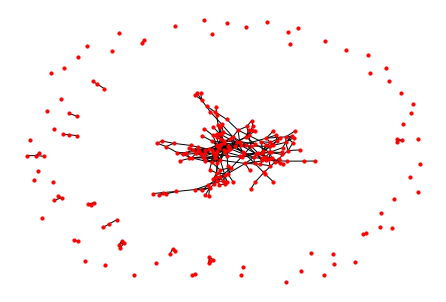

In [34]:
#from my_functions_new import *
global np
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
s = 'xdntc'
G = nx.from_numpy_matrix(ext_wat_ntc_community_without_tail('%s.GraphGeod' % s, 60, 120, 90, 3.5))
pos1 = pos = nx.spring_layout(G)
nx.draw(G, pos1, node_color='red', node_size=10)

In [36]:
conn_comp = nx.connected_component_subgraphs(G)
print(conn_comp)
cluster = [list(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
sorted_cluster = sorted(cluster,key = len, reverse=True)
print(len(sorted_cluster[0]))
rev_mice = []
for each in sorted_cluster[0]:
    each += 2409
    rev_mice.append(each)
print(str(rev_mice)[1:-1].replace(',',''))

<generator object connected_component_subgraphs at 0x0000003073AB5B48>
173
2410 2425 2431 2437 2442 2445 2446 2447 2450 2452 2454 2459 2463 2469 2470 2471 2472 2473 2474 2475 2476 2477 2478 2480 2481 2482 2484 2485 2486 2487 2488 2489 2491 2492 2493 2494 2495 2496 2497 2499 2501 2502 2503 2504 2505 2507 2508 2509 2510 2511 2512 2513 2514 2517 2518 2519 2520 2521 2522 2523 2525 2527 2528 2530 2531 2532 2533 2534 2535 2536 2537 2538 2539 2540 2541 2543 2544 2545 2546 2547 2548 2549 2553 2555 2557 2558 2559 2560 2561 2562 2563 2565 2567 2568 2569 2572 2573 2574 2575 2576 2577 2578 2579 2580 2581 2582 2583 2585 2587 2588 2589 2590 2591 2592 2593 2594 2595 2596 2597 2598 2600 2602 2604 2606 2608 2609 2610 2611 2612 2614 2615 2616 2617 2618 2619 2621 2626 2627 2629 2631 2632 2633 2634 2636 2637 2638 2639 2640 2641 2642 2644 2646 2647 2648 2649 2650 2653 2654 2655 2656 2658 2659 2660 2661 2662 2664 2667 2669 2670 2671 2672 2676 2678


In [6]:
def rearrange_gro_index_rev_micelle(file_name):
    import re
    f = open(file_name,'r')

    with open('10chxo.gro','w') as l:
    
        for line in f:
            strid= str(line).split()[0]
            temp = re.compile("([0-9]+)([a-zA-Z]+)") 
            res = temp.match(str(strid)).groups() 
            mol = res[1]
            mol_id = res[0]
            new = (int(mol_id)-2410)
            newstr = str(new)+str(mol)
            new_line = str(line).replace(strid,newstr)
            if mol == 'UNK':
                l.write(new_line)

    with open('10chxo.gro','a+') as l:
        f.seek(0)
        for line in f:
            strid= str(line).split()[0]
            temp = re.compile("([0-9]+)([a-zA-Z]+)") 
            res = temp.match(str(strid)).groups() 
            mol = res[1]
            mol_id = res[0]
            new = (int(mol_id)-2410)
            newstr = str(new)+str(mol)
            new_line = str(line).replace(strid,newstr)
            if mol == 'DGA':
                l.write(new_line)



    with open('10chxo.gro','a+') as l:
        f.seek(0)
        for line in f:
            strid= str(line).split()[0]
            temp = re.compile("([0-9]+)([a-zA-Z]+)") 
            res = temp.match(str(strid)).groups() 
            mol = res[1]
            mol_id = res[0]
            new = (int(mol_id)-2410)
            newstr = str(new)+str(mol)
            new_line = str(line).replace(strid,newstr)

            if mol == 'SOL':
                l.write(new_line)

    with open('10chxo.gro','a+') as l:
        f.seek(0)
        for line in f:
            strid= str(line).split()[0]
            temp = re.compile("([0-9]+)([a-zA-Z]+)") 
            res = temp.match(str(strid)).groups() 
            mol = res[1]
            mol_id = res[0]
            new = (int(mol_id)-2410)
            newstr = str(new)+str(mol)
            new_line = str(line).replace(strid,newstr)
            if mol == 'NITR':
                l.write(new_line)
    return()